In [105]:
# Name - Dev Patel
# Roll No - 18110113

import numpy as np
import scipy
import scipy.integrate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [106]:
# Some constants
l1 = 0.25
l2 = 0.25
l3 = 0.25
g = 9.81
m1 = 100
m2 = 100
m3 = 100
r = 0.01
q1 = 0
q2 = 0
d3 = 0
q1_I = 0
q2_I = 0
d3_I = 0
omega1 = 0
omega2 = 0
d3_dot = 0
d1 = 0.25
I1 = m1*r*r/12
I2 = m2*l2*l2/12
I3 = m3*r*r/2


# User Inputs
Coordinates= list(map(float, input("Initial End effector position:").split()))
P_i = np.array(Coordinates)

Coordinates= list(map(float, input("Final End effector position:").split()))
P_f = np.array(Coordinates)

In [107]:
# Get a skew symmetric matrix for a given 3x1 matrix
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


#STANFORD
def inverse_kinematics_Stanford(O):

    r = (O[0]**2 + O[1]**2)**0.5
    s = O[2] - l1
    theta1 = np.arctan2(O[1],O[0]) 
    d3 = (r**2 + s**2  - l2**2)**0.5
    theta2 = -np.arctan2(-s,r) + np.arctan2(d3,l2)
    

    I = np.array([theta1,theta2,d3])
    return(I)

q_i = inverse_kinematics_Stanford(P_i)
q_f = inverse_kinematics_Stanford(P_f)

print(q_i)
print(q_f)

# Forward Kinematics 

def end_Effector_position_Stanford(I):
    T = np.eye(4)
    DH_parameters = np.array([[I[0],0,l1,1.57],[I[1],l2,0,1.57],[0,0,I[2],0]])
    for i in range(3):
        A = np.array([[np.cos(DH_parameters[i,0]), -np.sin(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), np.sin(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.cos(DH_parameters[i,0])],\
                [np.sin(DH_parameters[i,0]), np.cos(DH_parameters[i,0])*np.cos(DH_parameters[i,3]), -np.cos(DH_parameters[i,0])*np.sin(DH_parameters[i,3]),DH_parameters[i,1]*np.sin(DH_parameters[i,0])],\
                    [0,np.sin(DH_parameters[i,3]),np.cos(DH_parameters[i,3]),DH_parameters[i,2]],\
                        [0,0,0,1]])

        T = np.dot(T,A)
    return(T[0:3,3])

print(end_Effector_position_Stanford(q_f))



[0. 0. 0.]
[ 1.57079633e+00 -1.11022302e-16  1.50000000e-01]
[2.38897937e-04 2.50000000e-01 1.00000190e-01]


In [132]:
def Stanfordmanipulator(t, y):
    '''
    function for the ODE solver - returns dy/dt of states
    '''

    d3_dot = y[8]
    omega2 = y[7]
    omega1 = y[6]
    d3 = y[5]
    q2 = y[4]
    q1 = y[3]
    d3_I = y[2]
    q2_I = y[1]
    q1_I = y[0]

    d11 = (m2*l2*l2*(np.cos(q2))**2)/4 + m3*(l2*np.cos(q2) + d3*np.sin(q2)/2)**2 +I1 + I2 + I3
    d22 = (m2*l2**2)/4 + m3*l2**2 + (m3*d3**2)/4 + I2 + I3
    d23 = -m3*l2*l2/4 + I3
    d32 = -m3*l2*l2/4 +I3
    d33 = m3/4 + I3

    A = omega1*omega2*(-l2*l2*m2*np.sin(q2)*np.cos(q2)/2 - 2*l2*l2*m3*np.sin(q2)*np.cos(q2) - l2*m3*d3*np.sin(q2)*np.sin(q2) + l2*m3*d3*np.cos(q2)*np.cos(q2) + m3*d3*d3*np.sin(q2)*np.cos(q2)/2) + omega1*d3_dot*(l2*m3*np.sin(q2)*np.cos(q2) + m3*d3*np.sin(q2)*np.sin(q2)/2)
    B = d3*m3*d3_dot/2 +omega1*omega1*(l2*l2*m2*np.sin(q2)*np.cos(q2)/4 + l2*l2*m3*np.sin(q2)*np.cos(q2) + l3*m3*d3*np.sin(q2)*np.sin(q2)/2 - l2*d3*m3*np.cos(q2)*np.cos(q2)/2 - d3*d3*m3*np.sin(q2)*np.cos(q2)/4) -g*l2*m2*np.cos(q2)/2 -g*l2*m3*np.cos(q2)/2 -g*d3*m3*np.sin(q2) 
    C = -m3*d3*omega2*omega2/4 + omega1*omega1*(-l2*m3*np.sin(q2)*np.cos(q2)/2 - m3*d3*np.sin(q2)*np.sin(q2)/4) +g*m3*np.cos(q2)
    K2 = 100
    K1 = -1
    K = -100

    dydt = [q1,q2, d3, omega1, omega2, d3_dot, -A/(d11-I1) - K*(q_f[0] - q1) - K2*omega1-K1*q1_I, (C*d23/(d33-I3)-B)/(d22 - I2 - d32/(d33-I3)) - K*(q_f[1]-q2) - K1*(q2_I) -K2*omega2,(-C-d32*((C*d23/(d33-I3)-B)/(d22 - I2 - d32/(d33-I3))))/(d33-I3) -K*(q_f[2]-d3) - K1*(d3_I) -K2*d3_dot]
    
    return dydt

q1 = q_i[0]
q2 = q_i[1]
d3 = q_i[2]
    
initstate = [q1_I,q2_I,d3_I,q1,q2, d3, omega1, omega2, d3_dot] # initial states
timestep = 0.1

time = np.linspace(0, 10, 1000) # define the time for which we want to solve


# solve the ODE
solution = solve_ivp(Stanfordmanipulator, [0, time[-1]], initstate, t_eval= time) 


qs1 = solution.y[3]
qs2 = solution.y[4]
ds3 = solution.y[5]
omegas1 = solution.y[6]
omegas2 = solution.y[7]
ds3_dot = solution.y[8]
time = solution.t


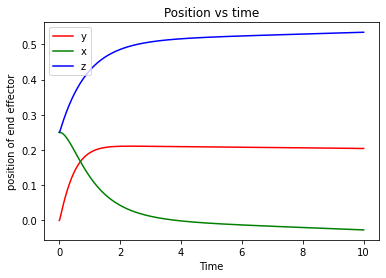

In [133]:
# For plotting the plots of end effector position
X = []
Y = []
Z = []

for i in range(len(qs1)):
    q1 = qs1[i]
    q2 = qs2[i]
    d3 = ds3[i]
    E = end_Effector_position_Stanford([q1,q2,d3])
    X.append(E[0])
    Y.append(E[1])
    Z.append(E[2])

plt.plot(time,Y,'r',time,X,'g',time,Z,'b')
plt.title('Position vs time')
plt.xlabel('Time')
plt.ylabel("position of end effector")
plt.legend(['y','x','z'])
plt.show()

In [ ]:
# Planar visualization.
%matplotlib tk
plt.ion()
plt.show()

for i in range(len(qs1)):
    q1 = qs1[i]
    q2 = qs2[i]
    d3 = ds3[i]

    # position of the links 
    ballpos1 = (l2*np.cos(q1)*np.cos(q2),l2*np.sin(q1)*np.cos(q2))

    plt.clf() # clear figure before each plot

    # set axis limits. 
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])

    # plot the 2R Manipulator
    hinge = (0, 0)
    plt.plot([hinge[0], ballpos1[0]], [hinge[1], ballpos1[1]], '-o')

    # pause so that the figure can be seen
    plt.pause(0.0001)

plt.ioff()
plt.show()